In [31]:
%matplotlib inline

In [32]:
pip install brian2

In [33]:
pip install --upgrade neurodynex

Requirement already up-to-date: neurodynex in /usr/local/lib/python3.7/dist-packages (0.3.4)


In [34]:
from neurodynex.brunel_model import LIF_spiking_network
from neurodynex.tools import plot_tools
import brian2 as b2
from brian2 import NeuronGroup, Synapses, PoissonInput
from brian2.monitors import StateMonitor, SpikeMonitor, PopulationRateMonitor
from random import sample
from numpy import random
import matplotlib.pyplot as plt

In [4]:
def reset_input(Excit,Inhib,P,w0,g,inputrate,ext,time):
  Excit = 800
  Inhib = 200
  P = 0.1
  w0 = 0.1 * b2.mV
  g = 1
  inputrate = 13. * b2.Hz
  ext = 0.1 * b2.mV
  time = 100. * b2.ms
  return (Excit,Inhib,P,w0,g,inputrate,ext,time)

In [5]:
Excit,Inhib,P,w0,g,inputrate,ext,time = 0,0,0,0,0,0,0,0
Excit,Inhib,P,w0,g,inputrate,ext,time = reset_input(Excit,Inhib,P,w0,g,inputrate,ext,time)

In [6]:
def run():
  rate_monitor, spike_monitor, voltage_monitor, idx_monitored_neurons = LIF_spiking_network.simulate_brunel_network(N_Excit=Excit,N_Inhib=Inhib,connection_probability=P,w0=w0,g=g,w_external=ext,poisson_input_rate=inputrate,sim_time=time)
  plot_tools.plot_network_activity(rate_monitor,spike_monitor,voltage_monitor,spike_train_idx_list=idx_monitored_neurons,t_min=0.*b2.ms)

INFO       width adjusted from 1. ms to 1.05 ms [brian2.monitors.ratemonitor.adjusted_width]


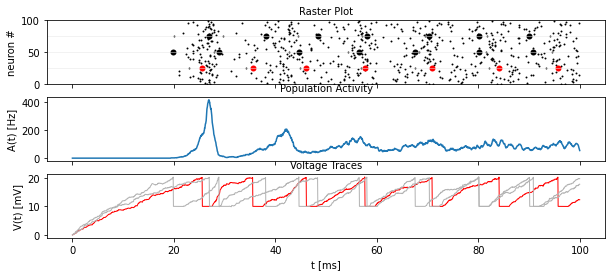

In [7]:
run()

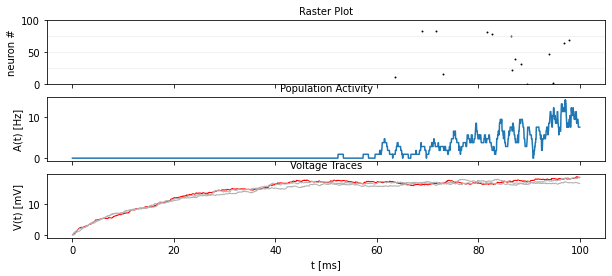

In [8]:
inputrate = 9. * b2.Hz
run()

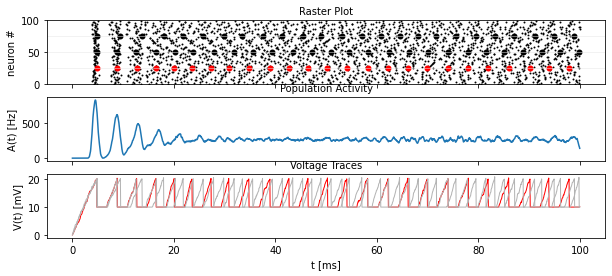

In [9]:
inputrate = 50. * b2.Hz
run()

In [10]:
Excit,Inhib,P,w0,g,inputrate,ext,time = reset_input(Excit,Inhib,P,w0,g,inputrate,ext,time)

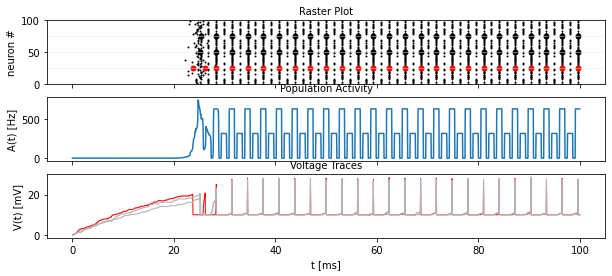

In [11]:
P = 0.8
run()

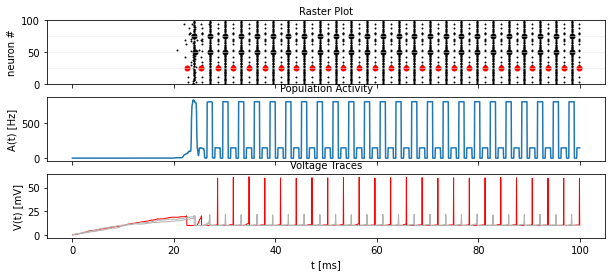

In [12]:
P = 1
run()

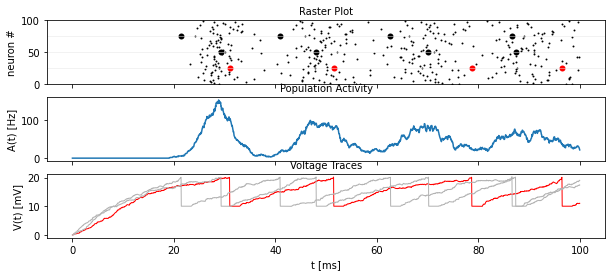

In [13]:
P = 0.01
run()

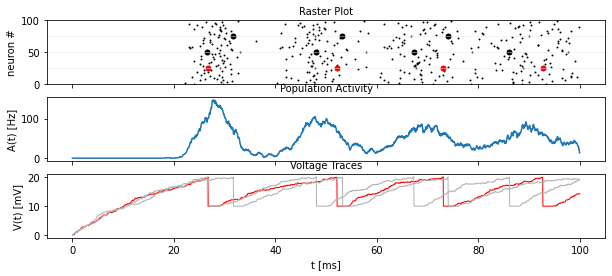

In [14]:
Excit,Inhib,P,w0,g,inputrate,ext,time = reset_input(Excit,Inhib,P,w0,g,inputrate,ext,time)
w0 = 0.01* b2.mV
run()

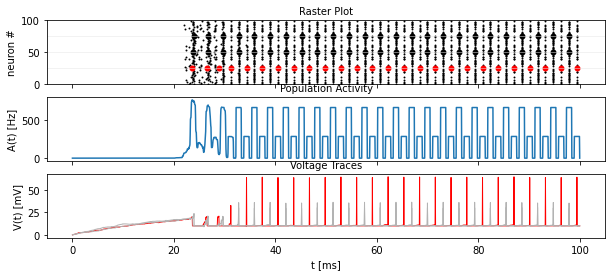

In [15]:
Excit,Inhib,P,w0,g,inputrate,ext,time = reset_input(Excit,Inhib,P,w0,g,inputrate,ext,time)
w0 = 1* b2.mV
run()

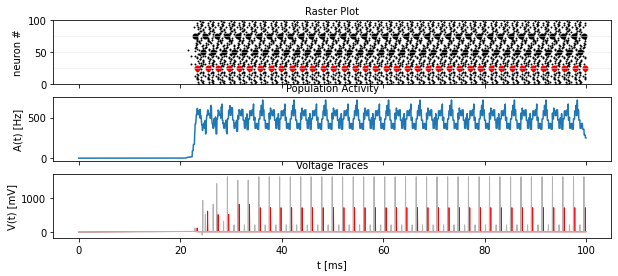

In [16]:
w0 = 100* b2.mV
run()

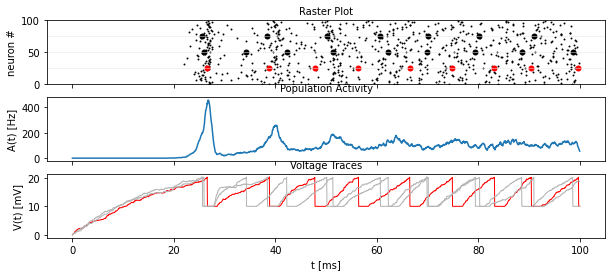

In [18]:
Excit,Inhib,P,w0,g,inputrate,ext,time = reset_input(Excit,Inhib,P,w0,g,inputrate,ext,time)
g = 0
run()

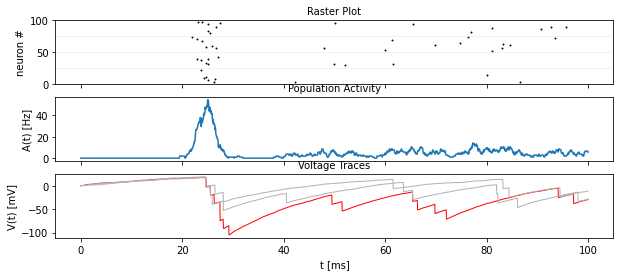

In [19]:
g = 200
run()

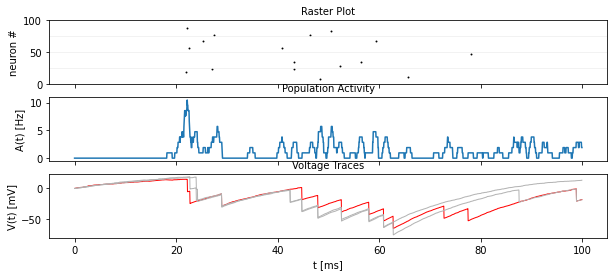

In [ ]:
P = 0.5
g = 200
run()

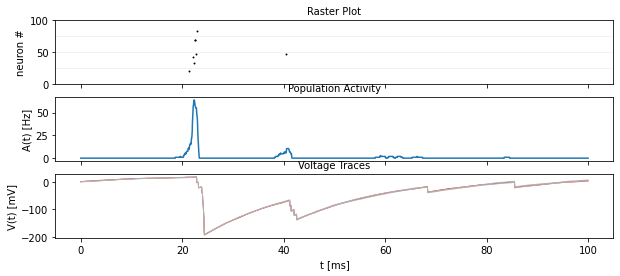

In [20]:
P = 1
g = 200
run()

In [35]:
V_REST = 0.1 * b2.mV
V_RESET = +10. * b2.mV
FIRING_THRESHOLD = +20. * b2.mV
MEMBRANE_TIME_SCALE = 20. * b2.ms
ABSOLUTE_REFRACTORY_PERIOD = 2.0 * b2.ms
SYNAPTIC_WEIGHT_W0 = 0.1 * b2.mV
RELATIVE_INHIBITORY_STRENGTH_G = 1.  
CONNECTION_PROBABILITY_EPSILON = 0.1
SYNAPTIC_DELAY = 1.5 * b2.ms
POISSON_INPUT_RATE = 13. * b2.Hz
N_POISSON_INPUT = 1000

In [36]:
prob = [[0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1]
       ]
N_Pop0=200
N_Pop1=200
N_Pop2=200

b2.defaultclock.dt = 0.05 * b2.ms

In [37]:
def simulate_brunel_network(
        N_extern=N_POISSON_INPUT,
        connection_probability=CONNECTION_PROBABILITY_EPSILON,
        w0=SYNAPTIC_WEIGHT_W0,
        g=RELATIVE_INHIBITORY_STRENGTH_G,
        synaptic_delay=SYNAPTIC_DELAY,
        poisson_input_rate=POISSON_INPUT_RATE,
        w_external=None,
        v_rest=V_REST,
        v_reset=V_RESET,
        firing_threshold=FIRING_THRESHOLD,
        membrane_time_scale=MEMBRANE_TIME_SCALE,
        abs_refractory_period=ABSOLUTE_REFRACTORY_PERIOD,
        monitored_subset_size=100,
        sim_time=100.*b2.ms):
    
    if N_extern is None:
        N_extern = int(N_Pop1*connection_probability)
    if w_external is None:
        w_external = w0

    J_excit = w0
    J_inhib = -g*w0
    
    lif_dynamics = """
    dv/dt = (-(v-v_rest) ) / membrane_time_scale : volt (unless refractory)"""

    network = NeuronGroup(
        N_Pop1+N_Pop2+N_Pop0, model=lif_dynamics,
        threshold="v>firing_threshold", reset="v=v_reset", refractory=abs_refractory_period,
        method="linear")

    network.v = v_rest

    pop = {}
    pop[0] = network[:N_Pop0]
    pop[1] = network[N_Pop0:N_Pop0+N_Pop1]
    pop[2] = network[N_Pop0+N_Pop1:]

    synapses = [[[]for i in range(3)]for i in range(3)]

    for i in range(3):
        for j in range(3):
            if i==2:
                synapses[i][j] = Synapses(pop[i], target=pop[j], on_pre="v += J_inhib", delay=synaptic_delay)
            else:
                synapses[i][j] = Synapses(pop[i], target=pop[j], on_pre="v += J_excit", delay=synaptic_delay)
            synapses[i][j].connect(p=prob[i][j])

    external_poisson_input = PoissonInput(target=network, target_var="v", N=N_extern,
                                          rate=poisson_input_rate, weight=w_external)

    # collect data of a subset of neurons:
    monitored_subset_size = min(monitored_subset_size, (N_Pop0+N_Pop1+N_Pop2))
    idx_monitored_neurons = sample(range(N_Pop0+N_Pop1+N_Pop2), monitored_subset_size)
    rate_monitor = PopulationRateMonitor(network)
    # record= some_list is not supported? :-(
    spike_monitor = SpikeMonitor(network, record=idx_monitored_neurons)
    voltage_monitor = StateMonitor(network, "v", record=idx_monitored_neurons)

    b2.run(sim_time)
    return rate_monitor, spike_monitor, voltage_monitor, idx_monitored_neurons


In [38]:
def run2():
  rate_monitor, spike_monitor, voltage_monitor, monitored_spike_idx = simulate_brunel_network(sim_time=100. * b2.ms)
  plot_tools.plot_network_activity(rate_monitor, spike_monitor, voltage_monitor, spike_train_idx_list=monitored_spike_idx, t_min=0.*b2.ms)


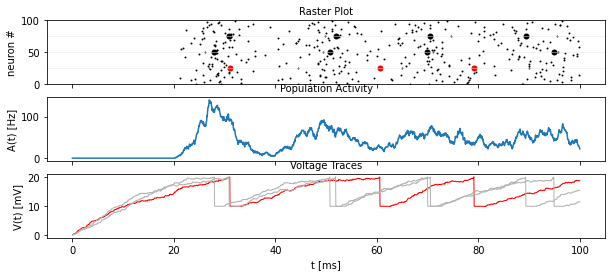

In [39]:
run2()